# Gradient Boosted Trees
XGBoost is the primary implementation of gradient boosted trees used in Python. Here, we train a classifier on the [UCI Hearts disease dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) to predict whether a give patient has heart disease based on 13 attributes.

## Loading in the Data
First, we import all the necessary libraries as well as the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('heartdisease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.shape

(303, 14)

We have 303 observations, each with 14 attributes out of which 13 are features and the last one is the target column.

In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Clearly, the features *cp, slope and thal* are categorical whereas *sex, exang, fbs* are binary and *restecg, ca* are ordinal.

## Exploratory Data Analysis
This is a necessary step to gauge the quality of the data. First, we need to check the value counts in the target column to make sure they aren't skewed tpwards one result.

In [6]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

<BarContainer object of 2 artists>

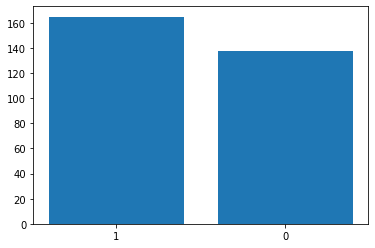

In [7]:
plt.bar(['1','0'], height=df.target.value_counts())

In [8]:
df.groupby('sex')['target'].value_counts()

sex  target
0    1          72
     0          24
1    0         114
     1          93
Name: target, dtype: int64

In [9]:
df.groupby('target').mean()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,56.601449,0.826087,0.478261,134.398551,251.086957,0.159420,0.449275,139.101449,0.550725,1.585507,1.166667,1.166667,2.543478
1,52.496970,0.563636,1.375758,129.303030,242.230303,0.139394,0.593939,158.466667,0.139394,0.583030,1.593939,0.363636,2.121212


In [10]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


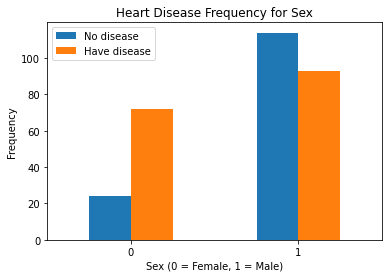

In [11]:
pd.crosstab(df.sex,df.target).plot(kind="bar")
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["No disease", "Have disease"])
plt.ylabel('Frequency')
plt.show()

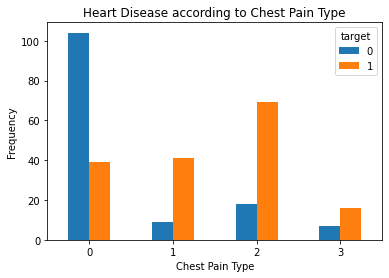

In [12]:
pd.crosstab(df.cp,df.target).plot(kind="bar")
plt.title('Heart Disease according to Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

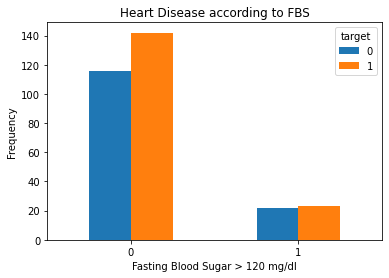

In [13]:
pd.crosstab(df.fbs,df.target).plot(kind="bar")
plt.title('Heart Disease according to FBS')
plt.xlabel('Fasting Blood Sugar > 120 mg/dl')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

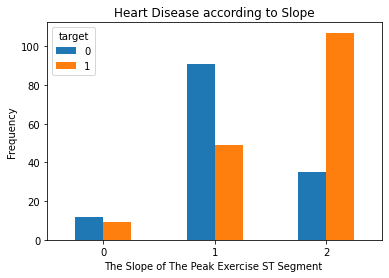

In [14]:
pd.crosstab(df.slope,df.target).plot(kind="bar")
plt.title('Heart Disease according to Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

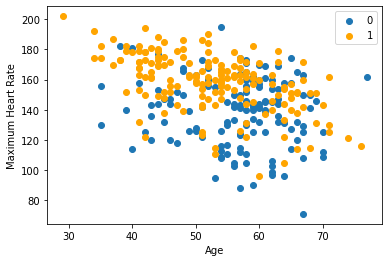

In [15]:
plt.scatter(x=df.age[df.target==0], y=df.thalach[(df.target==0)])
plt.scatter(x=df.age[df.target==1], y=df.thalach[(df.target==1)], c="orange")
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.legend(['0', '1'])
plt.show()

## Data Preprocessing
Here, we check for the presence of missing values and handle them accordingly. Then, we one-hot encode the categorical features.

In [16]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [17]:
new_df = pd.get_dummies(df, columns = ['cp','slope','thal'])
new_df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,1,145,233,1,0,150,0,2.3,0,...,0,0,1,1,0,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,...,0,1,0,1,0,0,0,0,1,0
2,41,0,130,204,0,0,172,0,1.4,0,...,1,0,0,0,0,1,0,0,1,0
3,56,1,120,236,0,1,178,0,0.8,0,...,1,0,0,0,0,1,0,0,1,0
4,57,0,120,354,0,1,163,1,0.6,0,...,0,0,0,0,0,1,0,0,1,0


## Model Training

In [18]:
y = new_df.pop('target')
X = new_df

print(X.shape, y.shape)

(303, 21) (303,)


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=39)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(212, 21) (91, 21)
(212,) (91,)


In [51]:
model = xgboost.XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train, eval_metric='error')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [52]:
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


Above, we can see all the hyperparameters the model has selected by default. Since we have a simple dataset, we do not expect the need of tuning as the default values should perform well enough. We mention `use_label_encoder=False` to prevent a warning message about version depreciation and `eval_metric='error'` as our target is binary.

In [53]:
from sklearn.metrics import accuracy_score, plot_roc_curve

print("Training accuracy: ", accuracy_score(model.predict(X_train), y_train))

Training accuracy:  1.0


In [54]:
y_pred = model.predict(X_test)
print("Test accuracy: ", accuracy_score(y_pred, y_test))

Test accuracy:  0.8241758241758241


As clearly seen above, we got a training accuracy of 100% but a test of accuracy of 82.4%, indicating that there is some overfitting in the model. Let us plot the ROC curve now.

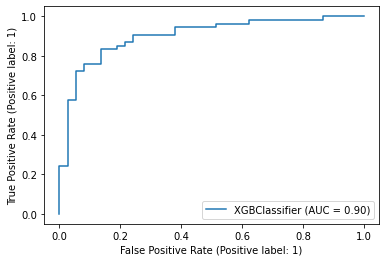

In [55]:
plot_roc_curve(model, X_test, y_test)

The AUC is 0.9, which is very close to ideal. 

## Tuning
We do tuning manually here, but it could just as easily be done using Scikit-Learn's implementation of [K-fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [56]:
tuned_model = xgboost.XGBClassifier(gamma=3, learning_rate=0.05, use_label_encoder=False)
tuned_model.fit(X_train, y_train, eval_metric='error')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [57]:
print("Training accuracy: ", accuracy_score(tuned_model.predict(X_train), y_train))
y_pred_tuned = tuned_model.predict(X_test)
print("Test accuracy: ", accuracy_score(y_pred_tuned, y_test))

Training accuracy:  0.910377358490566
Test accuracy:  0.8351648351648352


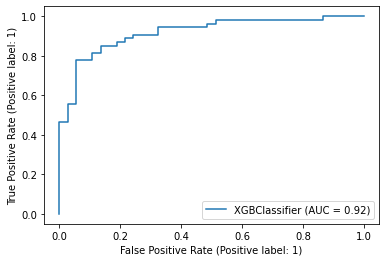

In [58]:
plot_roc_curve(tuned_model, X_test, y_test)

We get a lower training accuracy, but is closer to the test accuracy and our AUC has improved to 0.92.